<a href="https://colab.research.google.com/github/finardi/IA376J/blob/master/Aula3_Captioning___.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Oct  7 02:47:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data

In [3]:
!mkdir data
!gsutil -m cp -n gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula3/*_IMAGES_coco_5_cap_per_img.hdf5 data/.
!gsutil -m cp -n gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula3/*_CAPTIONS_coco_5_cap_per_img.json data/.

#-------------------------------------------------------------------------------------
train_path_captions = '/content/data/TRAIN_CAPTIONS_coco_5_cap_per_img.json'
train_path_imgs     = '/content/data/TRAIN_IMAGES_coco_5_cap_per_img.hdf5'

val_path_captions = '/content/data/VAL_CAPTIONS_coco_5_cap_per_img.json'
val_path_imgs     = '/content/data/VAL_IMAGES_coco_5_cap_per_img.hdf5'

test_path_captions = '/content/data/TEST_CAPTIONS_coco_5_cap_per_img.json'
test_path_imgs     = '/content/data/TEST_IMAGES_coco_5_cap_per_img.hdf5'

Copying gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula3/TEST_IMAGES_coco_5_cap_per_img.hdf5...
Copying gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula3/VAL_IMAGES_coco_5_cap_per_img.hdf5...
Copying gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula3/TRAIN_IMAGES_coco_5_cap_per_img.hdf5...
\ [3/3 files][  4.7 GiB/  4.7 GiB] 100% Done  18.4 MiB/s ETA 00:00:00           
Operation completed over 3 objects/4.7 GiB.                                      
Copying gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula3/TEST_CAPTIONS_coco_5_cap_per_img.json...
Copying gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula3/TRAIN_CAPTIONS_coco_5_cap_per_img.json...
Copying gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula3/VAL_CAPTIONS_coco_5_cap_per_img.json...
| [3/3 files][  6.8 MiB/  6.8 MiB] 100% Done                                    
Operation completed over 3 objects/6.8 MiB.                                      


# Import  e instação das bibliotecas

In [4]:
! pip install -q einops
! pip install -q sacrebleu
! pip install -q transformers
! pip install -q efficientnet_pytorch

     |████████████████████████████████| 71kB 2.2MB/s 
     |████████████████████████████████| 1.1MB 2.8MB/s 
     |████████████████████████████████| 1.1MB 17.9MB/s 
     |████████████████████████████████| 3.0MB 25.0MB/s 
     |████████████████████████████████| 890kB 24.6MB/s 
     |████████████████████████████████| 51kB 1.7MB/s 


In [5]:
import gc
import math
import nltk
import h5py
import json
import torch
import pprint
import sacrebleu
import numpy as np
import pandas as pd
import torch.nn as nn
from einops import rearrange
from collections import Counter
import torch.nn.functional as F
from torchvision import transforms
import efficientnet_pytorch as efp
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.nn import TransformerDecoder, TransformerDecoderLayer

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
#================= Experimentos determnísticos e seeds =================#
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
manual_seed = 2711 

def deterministic(rep=True):
    if rep:
        np.random.seed(manual_seed)
        torch.manual_seed(manual_seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(manual_seed)
            torch.cuda.manual_seed_all(manual_seed)
        torch.backends.cudnn.enabled = False 
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        print(f'Experimento deterministico, seed: {manual_seed} -- ', end = '')
        print(f'Existe {torch.cuda.device_count()} GPU {torch.cuda.get_device_name(0)} disponível.')
    else:
        print('Experimento randomico')

deterministic()

Experimento deterministico, seed: 2711 -- Existe 1 GPU Tesla P100-PCIE-16GB disponível.


#  Funções úteis

In [7]:
#================= Computa Loss =================#
class ComputeMetrics(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
#================= Converte a saída do decoder em palavra =================#
def net_output2word(decoder_out, itos):
    tokens = decoder_out
    tokens = tokens.transpose(1, 0)
    tokens = tokens.cpu().numpy()
    results = []
    for instance in tokens:
        result = ' '.join([itos[x] for x in instance])
        results.append(''.join(result.partition('<eos>')[0])) # para a sentença antes do '<eos>'
    return results

#================= Gera o corpus do texto de referência para o Bleu =================#
def get_reference_corpus(id, path):
    captions_id = get_dic_id_caption(path)
    
    for num in range(5):
        caption_candidates = captions_id[id]
        reference_corpus = [x.split() for x in [''.join(captions_id[id])]]
    reference_corpus = np.array(reference_corpus)
    return reference_corpus

#================= Calcula o o Bleu para a média do conj. de teste =================#
def get_bleu_score(result_collection, path_captions):
    test_refs = get_dic_id_caption(path_captions)
    total_bleu, refs_in_dict_list = 0, {}

    for id, list_text in test_refs.items():
        samples = []
        for sample in list_text:
            samples.append([sample])
        refs_in_dict_list[id] = samples
        total_bleu += sacrebleu.corpus_bleu(result_collection[id], 
                                            refs_in_dict_list[id]).score

    return total_bleu/len(test_refs)

# Dataset e Tokenização

In [31]:
#================= Todos os Captions =================#
def get_dic_id_caption(path):
    captions_dict = {}
    
    with open(path, "rb") as handle:
        captions = json.loads(handle.read())
    
    for i, sentences in enumerate(captions):
        captions_dict[i] = sentences
    
    return captions_dict

words_train = get_dic_id_caption(train_path_captions)

#================= Tokeniza os Captions =================#
def tokenize_captions(dict_captions,frequency=2):
    counter = Counter()
    for _,list_captions in dict_captions.items():
        for capt_sample in list_captions:
            for word in nltk.word_tokenize(capt_sample):   
                counter.update([word.lower()])
    return counter

words_train_tokenized = tokenize_captions(words_train)

#================= str2ind e int2str dicts =================#
def get_str2idx_and_int2str(dict_tokenized, frequency=2):
    words_ = {k:v for k,v in dict_tokenized.items() if v >= frequency}
    words_ = sorted(words_, key=words_.get, reverse=True)
    words_ = ['<pad>', '<sos>', '<eos>', '<unk>'] + words_

    # dict int2char e char2int
    stoi = {o:i for i,o in enumerate(words_)}
    itos = {i:o for i,o in enumerate(words_)}

    return stoi, itos

stoi, itos = get_str2idx_and_int2str(words_train_tokenized, frequency=3)

print(f'Vocab size: {len(stoi)}')
assert len(stoi) == len(itos), f'ERRO de SHAPE'

Vocab size: 6169


In [32]:
#================= Transformação na imagem =================#
train_transforms = [transforms.ToPILImage(),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(), 
                    transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                                         std=[0.5, 0.5, 0.5])
                    ]
train_data_transform = transforms.Compose(train_transforms)

#================= Classe Dataset =================#
class DataCaptioning(Dataset):
    def __init__(self, path_h5, path_captions, transforms=None, truncation=60):
        
        with open(path_captions, "rb") as handle:
            self.captions = json.loads(handle.read())

        self.h = h5py.File(path_h5, 'r')
        self.imgs = self.h['images']
        self.transform = transforms
        self.truncation = truncation

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        img = torch.FloatTensor(self.imgs[index])
        if self.transform is not None:
            img = self.transform(img)
        
        captions = self.captions[index]
        
        tokens = [token for sample in captions for token \
                  in nltk.tokenize.word_tokenize(sample.lower())]
        
        caption_encoded = []
        
        caption_encoded.append(stoi['<sos>'])
        caption_encoded.extend([stoi[token] if token in stoi else \
                                stoi['<unk>'] for token in tokens])
        caption_encoded.append(stoi['<eos>'])
        
        padded_caption = np.zeros(self.truncation)
        
        # 60 tokens é a média das 5 legendas concatenadas
        if len(caption_encoded) > self.truncation: 
            caption_encoded = caption_encoded[:self.truncation]
        padded_caption[:(len(caption_encoded))] = np.array(caption_encoded)
        captions = torch.tensor(padded_caption).long()

        return img, captions

#================= Teste do Dataset =================#
ds = DataCaptioning(train_path_imgs, train_path_captions, transforms=train_data_transform)
x, cap = ds[0]
cap

tensor([   1,    4,   48,    8,    4,   79,   10,    4,   14,    5,    4,   48,
          12,   61,    4,   14,    8,  125,  164,    4,   48,   12,   61,    4,
          14,    8,  125,  164,    5,    4,  166,  963,  127,  852,  296,    4,
          14,   11, 1268,    4,  871,  348, 2561,    5,    4,   48,   12,  622,
           8,    4,  164,  254,    4, 1336,  217,    5,    2,    0,    0,    0])

# Transformer

In [33]:
#================= Encoder: CNN - EfficientNet =================#
class EncoderEfficientNET(nn.Module):
    def __init__(self, model, channels, embed_size):
        super(EncoderEfficientNET, self).__init__()
        
        self.features = model.extract_features
        self.conv1 = nn.Conv2d(channels, embed_size, 1)
        self.embed_size = embed_size
        
    def forward(self, x):
        output = self.features(x) # N, C=1280, H, W
        output = self.conv1(output)
        output = output.view(output.size(0), self.embed_size, -1)
        # HW, N, d_model (como o transf. layer inverte o batch, 
        # farei o mesmo aqui para depois o batch retornar a 1a dim.
        output = output.permute(2, 0, 1) 

        return output

#================= Encoder: CNN - Resnet =================#
class EncoderResnet(nn.Module):
    def __init__(self, cnn, channels, embed_size):
        super(EncoderResnet, self).__init__()
        self.cnn = nn.Sequential(*list(cnn.children())[:-2])
        self.conv1 = nn.Conv2d(channels, embed_size, 1)
        self.embed_size = embed_size
        
    def forward(self, x):
        output = self.cnn(x) # N, C=2048 H, W
        output = self.conv1(output)
        output = output.view(output.size(0), self.embed_size, -1)
        # HW, N, d_model (como o transf. layer inverte o batch, 
        # farei o mesmo aqui para depois o batch retornar a 1a dim.
        output = output.permute(2, 0, 1) 

        return output

    def freeze_bottom(self):
        for p in self.cnn.parameters():
            p.requires_grad = False
        for c in list(self.cnn.children())[-2:]: # Treina só os 2 últimos blocos
            for p in c.parameters():
                p.requires_grad = True

#================= Pos enbeddings: código do `The Annotated Transformers` =================#
class PositionEncoder(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionEncoder, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *\
                             (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

#================= Decoder: TransformerDecoderLayer =================#
class TransformerCaptioning(nn.Module):
    def __init__(self, vocab_size, d_model, nHead, nHidden, nLayers, dropout_pos=0.1):
        super(TransformerCaptioning, self).__init__()

        self.d_model = d_model
        self.tgt_mask = None

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_enc = PositionEncoder(d_model, dropout_pos, max_len=60)
        
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model, 
            nhead=nHead, 
            dim_feedforward=nHidden
            )
        self.transformer_decoder = nn.TransformerDecoder(
            decoder_layer, 
            num_layers=nLayers
            )
        self.linear = nn.Linear(d_model, vocab_size)
        
    def get_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask==0, 
                                    float('-inf')).masked_fill(mask==1, float(0.0))
        return mask

    def forward(self, src, tgt): # src: img_encoder, tgt: captions

        tgt = rearrange(tgt, 'n t -> t n') # igual transpose(0,1)

        if self.tgt_mask is None or self.tgt_mask.size(0) != len(tgt):
            self.tgt_mask = self.get_mask(tgt.size(0)).cuda()
        
        tgt = self.pos_enc(self.embedding(tgt) * math.sqrt(self.d_model))

        output = self.transformer_decoder(
            tgt=tgt, 
            memory=src, 
            tgt_mask=self.tgt_mask,
            )

        output = self.linear(output)

        return output
    
    # greedy
    def generate(self, src, max_pred=20): 
            tgt = torch.ones((max_pred, src.size(1)), dtype=int) * 2
            
            if self.tgt_mask is None or self.tgt_mask.size(0) != len(tgt):
                tgt_mask = self.get_mask(len(tgt)).cuda()
            
            output = torch.ones((max_pred, src.size(1)), dtype=int)
            tgt, output = tgt.cuda(), output.cuda()
            
            for i in range(max_pred):
                tgt_emb = self.pos_enc(self.embedding(tgt) * math.sqrt(self.d_model))
                
                out = self.transformer_decoder(
                    tgt=tgt_emb, 
                    memory=src, 
                    tgt_mask=tgt_mask
                    )
                
                out = out[i]
                out = self.linear(out) 
                out = out.argmax(dim=1)
                if i < max_pred-1:
                    tgt[i+1] = out
                output[i] = out
            
            return output

# Funções de treino e validação

In [34]:
#================= Função de treino =================#
def train_model(vocab_size, encoder, decoder, criterion, train_dataloader, 
                enc_optimizer, dec_optimizer):

    encoder.train()
    decoder.train()
    
    train_loss = ComputeMetrics()
    for batch_index, (inputs, captions) in enumerate(train_dataloader):
        inputs, captions = inputs.cuda(), captions.cuda()
        
        enc_optimizer.zero_grad()
        dec_optimizer.zero_grad()
        
        captions_input = captions[:, :-1] # shift do input -> ideia de NMT
        captions_target = captions[:, 1:] # shift do output -> ideia de NMT
        
        enc_out = encoder(inputs)
        output = decoder(src=enc_out, tgt=captions_input) 
        output = output.permute(1, 0, 2) # desfaz a troca do transformer dec. layer
        
        loss = criterion(rearrange(output, 'n t v -> (n t) v'), 
                         rearrange(captions_target, 'n o -> (n o)'))
        loss.backward()
        
        enc_optimizer.step()
        dec_optimizer.step()
        
        train_loss.update(loss.item(), inputs.size(0))
        
        if batch_index % 50 == 0:
            print(f'\tLoss treino batch {batch_index:>3}: {loss.item():>{4}.3}')

    return train_loss.avg

#================= Função de validação =================#
def validate_model(vocab_size, encoder, decoder, criterion, val_dataloader):
    encoder.eval()
    decoder.eval()
    
    result_collection = []
    
    val_loss = ComputeMetrics()
    for batch_index, (inputs, captions) in enumerate(val_dataloader):
        inputs, captions = inputs.cuda(), captions.cuda()
    
        with torch.no_grad():
            enc_out = encoder(inputs)
            captions_input = captions[:, :-1] # shit no input 
            captions_target = captions[:, 1:] # e output (ideia do neural translate)
            output = decoder(src=enc_out, tgt=captions_input)
            out_gen = decoder.generate(src=enc_out, max_pred=20)
            result_caption = net_output2word(out_gen, itos)
            result_collection.extend(result_caption)

        output = output.permute(1, 0, 2) # desfaz a troca do transformer dec. layer

        loss = criterion(rearrange(output, 'n t e -> (n t) e'), 
                         rearrange(captions_target, 'n s -> (n s)'))
        
        val_loss.update(loss.item(), inputs.size(0))

    return val_loss.avg, result_collection

# Label Smoothing com mask no padding




In [35]:
class LabelSmoothLogSoftmax(nn.Module):

    def __init__(self, lb_smooth=0.1, ignore_index=stoi['<pad>']):
        super(LabelSmoothLogSoftmax, self).__init__()
        self.lb_smooth = lb_smooth
        self.lb_ignore = ignore_index
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, logits, label):
        logits = logits.float() 

        with torch.no_grad():
            num_classes = logits.size(1)
            label = label.clone().detach()
            ignore = label.eq(self.lb_ignore)
            n_valid = ignore.eq(0).sum()
            label[ignore] = 0
            lb_pos, lb_neg = 1. - self.lb_smooth, self.lb_smooth / num_classes
            lb_one_hot = torch.empty_like(logits).fill_(
                lb_neg).scatter_(1, label.unsqueeze(1), lb_pos).detach()

        logs = self.log_softmax(logits)
        loss = -torch.sum(logs * lb_one_hot, dim=1)
        loss[ignore] = 0
        loss = loss.sum() / n_valid

        return loss # <-- precisa testar a div. KL

# Loop de treino

In [36]:
#================= Configuração =================#
config = {
    'vocab_size': len(stoi),
    'epochs': 40,
    'batch_size': 32,
    'use efficientnet': False,
    'enc_sgd_lr': 1e-3,
    'smoothing': 0.1,
    'patience': 2,
    'patience_count': 0,
    'best_bleu': 0,
    'best_epoch': 0,
    'channels': [1280, 2048],
    'emb_size': 300,
    'nHead': 10,
    'hidden_size': 512,
    'nLayers': 2,
    'dropout_dec': 0.1,
    'dropout_pos': 0.1,
    'enc_save_path': '/content/drive/My Drive/Colab Notebooks/best_enc_epoc',
    'dec_save_path': '/content/drive/My Drive/Colab Notebooks/best_dec_epoc',
}
# Exp. determinísticos
deterministic()

#================= Datasets =================#
train_set = DataCaptioning(train_path_imgs, train_path_captions, transforms=train_data_transform)
val_set   = DataCaptioning(val_path_imgs, val_path_captions, transforms=train_data_transform)
test_set  = DataCaptioning(test_path_imgs, test_path_captions, transforms=train_data_transform)

#================= Dataloaders =================#
train_loader = DataLoader(
    train_set, batch_size=config['batch_size'], shuffle=True, pin_memory=True, num_workers=1)
val_loader = DataLoader(
    val_set, batch_size=config['batch_size'], shuffle=False, pin_memory=True, num_workers=1)
test_loader = DataLoader(
    test_set, batch_size=config['batch_size'], shuffle=False, pin_memory=True, num_workers=1)

#================= Encoder =================#
if config['use efficientnet']:
    print('EfficientNet encoder\n')
    effnet = efp.EfficientNet.from_pretrained('efficientnet-b0').cuda()       
    encoder = EncoderEfficientNET(effnet, config['channels'][0], config['emb_size']).cuda()
    del effnet
    gc.collect()
    torch.cuda.empty_cache()
else:
    print('Resnet encoder\n')
    resnet = models.resnet50(pretrained=True)
    encoder = EncoderResnet(resnet, config['channels'][1], config['emb_size']).cuda()    
    encoder.freeze_bottom()
    del resnet
    gc.collect()
    torch.cuda.empty_cache()

#================= Decoder =================#
decoder = TransformerCaptioning(config['vocab_size'], config['emb_size'], config['nHead'],
            config['hidden_size'], config['nLayers'], config['dropout_pos']).cuda()        

#================= Loss Otimizadores e Schedule =================#
enc_optimizer = torch.optim.SGD([p for p in encoder.parameters() \
                        if p.requires_grad],lr=config['enc_sgd_lr'], momentum=0.9, 
                        weight_decay=1e-4, nesterov=True)

dec_optimizer = torch.optim.AdamW(decoder.parameters())

smooth_criterion = LabelSmoothLogSoftmax(
    lb_smooth=config['smoothing'], 
    ignore_index=stoi['<pad>']
    )

#================= Loop de treino =================#
training_stats = []
for epoch_i in range(1, config['epochs']+1):
    print(f"Epoca [{epoch_i}/{config['epochs']}]")

    loss_train = train_model(config['vocab_size'], encoder, decoder, smooth_criterion, 
                        train_loader, enc_optimizer, dec_optimizer)
    
    loss_val, result_collection = validate_model(config['vocab_size'], 
                    encoder, decoder, smooth_criterion, val_loader)

    bleu = get_bleu_score(result_collection, val_path_captions)
    
    # Salva o melhor modelo
    if bleu > config['best_bleu']:
        config['patience_count'] = 0 # reset
        config['best_bleu'] = bleu
        config['best_epoch'] = epoch_i
        torch.save(encoder.state_dict(), config['enc_save_path'])
        torch.save(decoder.state_dict(), config['dec_save_path'])
    
    print(f'     -> Conj. de Validação época {epoch_i}: Loss: {loss_val:.3} \
-- Bleu score: {bleu:>{3}.3}')
    print(f'='*68)
    
    # Early stopping
    if config['best_bleu'] < bleu: 
        config['patience_count'] += 1
    if ['patience_count'] == config['patience']:
        print("Early Stopping !!!")
        break
    
    training_stats.append(
        {
            'epoch': epoch_i,
            'Training Loss': loss_train,
            'Valid Loss': loss_val,
            'Valid Bleu': bleu,
        }
    )

print(f'\nFEITO!')

Experimento deterministico, seed: 2711 -- Existe 1 GPU Tesla P100-PCIE-16GB disponível.
Resnet encoder



Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



Epoca [1/40]
	Loss treino batch   0: 8.88
	Loss treino batch  50: 5.05
	Loss treino batch 100: 4.54
	Loss treino batch 150:  4.7
	Loss treino batch 200: 4.34
	Loss treino batch 250: 3.93
	Loss treino batch 300:  4.2
	Loss treino batch 350: 4.37
	Loss treino batch 400: 4.23
	Loss treino batch 450: 3.93
	Loss treino batch 500: 3.97
	Loss treino batch 550: 4.23
	Loss treino batch 600: 3.91
	Loss treino batch 650: 3.95
	Loss treino batch 700: 4.09
     -> Conj. de Validação época 1: Loss: 3.87 -- Bleu score: 13.0
Epoca [2/40]
	Loss treino batch   0:  3.8
	Loss treino batch  50:  3.8
	Loss treino batch 100: 3.98
	Loss treino batch 150: 3.77
	Loss treino batch 200: 3.91
	Loss treino batch 250: 3.99
	Loss treino batch 300:  3.9
	Loss treino batch 350: 3.64
	Loss treino batch 400: 3.69
	Loss treino batch 450: 3.93
	Loss treino batch 500: 3.81
	Loss treino batch 550:  3.8
	Loss treino batch 600: 3.74
	Loss treino batch 650: 3.89
	Loss treino batch 700:  3.7
     -> Conj. de Validação época 2: 

KeyboardInterrupt: ignored

## Log do treino em dataframe

In [37]:
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
pd.set_option('precision', 3)
df_stats

,Training Loss,Valid Loss,Valid Bleu
epoch,,,
1,4.288,3.871,12.984
2,3.831,3.742,12.324
3,3.707,3.684,14.766
4,3.630,3.652,18.014
5,3.573,3.620,16.644


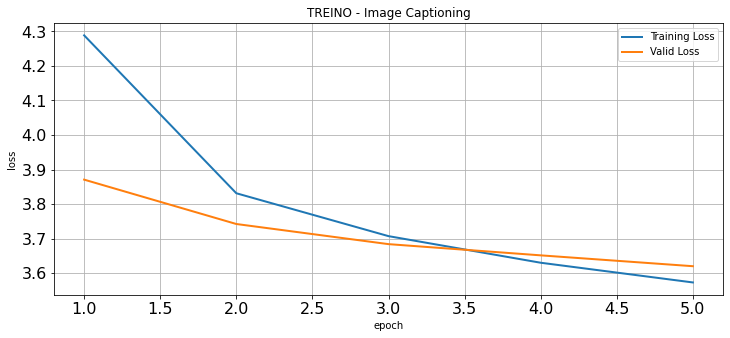

In [38]:
df_stats[['Training Loss', 'Valid Loss']].plot(
    figsize=(12, 5), 
    lw=2, 
    ylabel="loss", 
    fontsize=16, 
    grid=True, 
    title='TREINO - Image Captioning'
    )

# Eval

In [46]:
#================= Carrega os modelos =================#
encoder.load_state_dict(torch.load(config['enc_save_path']))
decoder.load_state_dict(torch.load(config['dec_save_path']))
encoder.eval()
decoder.eval()

#================= Faz o decode =================#
result_collection = []
with torch.no_grad():
    for batch_index, (inputs, captions) in enumerate(test_loader):
        inputs, captions = inputs.cuda(), captions.cuda()
        enc_out = encoder(inputs)
        out_gen = decoder.generate(src=enc_out, max_pred=20)
        result_caption = net_output2word(out_gen, itos)
        result_collection.extend(result_caption)

## Para um predict 

		::: TRUE LABELS :::
['a gentleman riding a horse down a city street.',
 'a man rides a horse down a city street.',
 'a man on a horse walking down the middle of a street.',
 'a mounted police officer riding down a city street past parked cars.',
 'man riding white horse in the street while others watch.']

PREDICT: '. a man riding a horse on a horse in a city . '


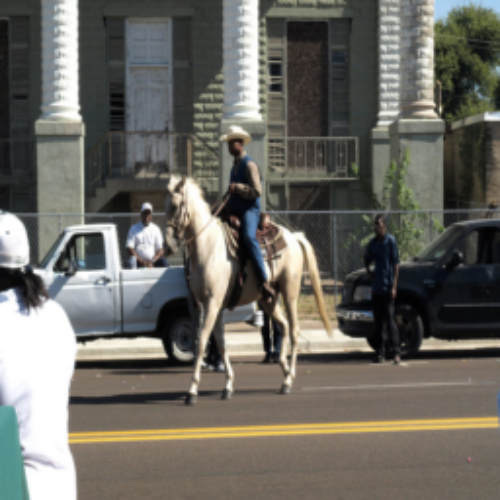

In [52]:
#================= Gera um exemplo com TRUE-LABLES e PREDICT =================#
def get_sample_img(path_img, path_caption, random_sample=True, n=None):
    img_pil = transforms.ToPILImage()    
    img_tensor = transforms.ToTensor()
    img_resize = transforms.Resize(500)

    with open(path_caption, "rb") as handle:
        captions = json.loads(handle.read())

    ds = DataCaptioning(path_img, path_caption)
    if random_sample and n is None:
        picked = np.random.randint(0, len(ds))
        cap = captions[picked]
        cap = [s.lower() for s in cap]
        img, _ = ds[picked]
        predict = result_collection[picked]
    if n is not None:
        cap = captions[n]
        cap = [s.lower() for s in cap]
        img, _ = ds[n]
        predict = result_collection[n]
    
    print('\t\t===================')
    print('\t\t::: TRUE LABELS :::')
    print('\t\t===================')
    pprint.PrettyPrinter(indent=1, width=100).pprint(cap)
    
    print('\nPREDICT: ', end='')
    pprint.PrettyPrinter(indent=1, width=150).pprint(predict)

    img = img.numpy().transpose(1,2,0).astype(np.uint8)
    img = img_pil(img)
    return img_resize(img)


get_sample_img(test_path_imgs, test_path_captions)

## Cálculo do bleu para todo o conj. de teste

In [48]:
avg_bleu = get_bleu_score(result_collection, test_path_captions)
print(f'Blue total score: {avg_bleu:.3}')

Blue total score: 17.8


# Fim